## Predictive model - Classification

In this notebook, data clusters are examined

Dataset: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

### Attribute Information:

#### bank client data:

1.  **age** (numeric)
2.  **job** : type of job (categorical: 'admin.','bluecollar','entrepreneur','housemaid','management','retired','selfemployed','services','student','technician','unemployed','unknown')
3.  **marital** : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4.  **education** (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5.  **default**: has credit in default? (categorical: 'no','yes','unknown')
6.  **housing**: has housing loan? (categorical: 'no','yes','unknown')
7.  **loan**: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:
8.  **contact**: contact communication type (categorical: 'cellular','telephone')
9.  **month**: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10.  **day_of_week**: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11.  **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:
12.  **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13.  **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14.  **previous**: number of contacts performed before this campaign and for this client (numeric)
15.  **poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes
16.  **emp.var.rate**: employment variation rate  quarterly indicator (numeric)
17.  **cons.price.idx**: consumer price index  monthly indicator (numeric)
18.  **cons.conf.idx**: consumer confidence index  monthly indicator (numeric)
19.  **euribor3m**: euribor 3 month rate  daily indicator (numeric)
20.  **nr.employed**: number of employees  quarterly indicator (numeric)
21.  **y**  has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
# import all the libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 

import random
random.seed(123)

from IPython.display import display
import random
import time

pd.options.display.max_columns = None
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("bank-additional/bank-additional-full.csv", sep =";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Data Preprocessing

In [3]:
map_dict= {"no":0, "yes":1}
df["y"] = df["y"].map(map_dict)

### Filling missing values

In [4]:
text_cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact']

In [5]:
cat_values_dict = {}
for col in text_cat_columns:
#     print("Column: %s, Number of unique values: %d"% (col, df[col].nunique()))
    cat_values_dict[col] = list(set(df[col].unique())-set(["unknown"]))

# filling with random values from lists of availbale categories

for col in text_cat_columns:
    n_missing = df[df[col]=="unknown"].shape[0]
    missing_index = df[df[col]=="unknown"].index
    print(col, n_missing)
    fill_vallues = cat_values_dict[col]*n_missing
    random.shuffle(fill_vallues)
    df.loc[missing_index, col]= fill_vallues[:n_missing]

job 330
marital 80
education 1731
default 8597
housing 990
loan 990
contact 0


In [7]:
# OHE - dummies columns
df1 = pd.get_dummies(df)
print("Original data: {}, Encoded data: {}".format(df.shape, df2.shape))

Original data: (41188, 21), Encoded data: (41188, 21)


In [8]:
# Scaling for continious variables
from sklearn.preprocessing import StandardScaler

numerical_columns = ['age', 'duration','campaign','pdays','previous','emp.var.rate','cons.price.idx',
                     'cons.conf.idx','euribor3m','nr.employed']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df1[numerical_columns])

features = df1.drop("y", axis=1).columns

## Choosing the right number of clusters

In [9]:
from sklearn.cluster import KMeans

In [10]:
%%time
n_clusters = 20
kmeans_kwargs = {"init": "random", "max_iter": 300, "random_state": 123}

errors = []
for i in range(2, n_clusters+1):
    kmeans = KMeans(n_clusters=i, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    errors.append(kmeans.inertia_) # inertia is a within-cluster sum-of-squares

CPU times: user 1min 1s, sys: 4.15 s, total: 1min 5s
Wall time: 1min 15s


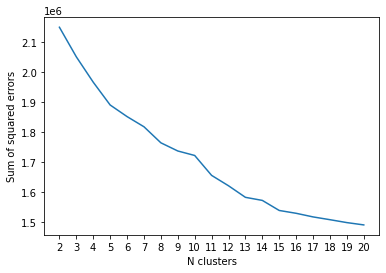

In [11]:
plt.plot(np.arange(2, n_clusters+1), errors)
plt.xlabel("N clusters")
plt.xticks(np.arange(2, n_clusters+1))
plt.ylabel("Sum of squared errors");

Considering elbow method,13 clusters seem to be optimal for the current dataset

## Analysis of clusters

### Approach A (13 clusters)

In [19]:
kmeans = KMeans(n_clusters=13)
kmeans.fit(scaled_features)
df1["cluster"] = kmeans.predict(scaled_features)

In [20]:
df1["cluster"].value_counts()

11    6037
7     5465
12    4837
6     4454
4     3771
5     3485
2     3468
1     2534
10    2458
0     1702
9     1307
3     1124
8      546
Name: cluster, dtype: int64

In [21]:
df1.groupby("cluster")[numerical_columns+["y"]].mean().sort_values("y", ascending=False)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
cluster,,,,,,,,,,,
9,42.091048,323.392502,1.815608,5.605968,1.592196,-2.102831,93.342254,-38.603826,1.014774,5031.151109,0.640398
8,40.778388,245.946886,2.203297,835.454212,0.483516,-1.800000,93.097330,-42.650549,1.162745,5055.390110,0.505495
3,44.542705,290.781139,1.689502,977.014235,0.411922,-2.464324,93.096257,-33.540214,1.063661,5014.172865,0.369217
10,40.362083,291.135476,1.961351,999.000000,0.238405,-1.800000,93.105711,-46.530431,1.377235,5094.980879,0.187144
12,37.578251,259.189787,2.256564,999.000000,0.000000,-2.041968,92.912626,-43.454352,1.206191,5086.164875,0.173868
1,38.702841,245.716654,2.107735,962.694159,1.198895,-1.991042,92.989655,-43.363496,1.181901,5079.385596,0.144830
5,40.806600,240.873458,1.896126,999.000000,0.193974,-0.246428,93.197941,-41.632166,3.938289,5185.587862,0.072023
0,40.146886,262.868978,2.675088,999.000000,0.003525,0.562632,93.751083,-40.686722,4.140522,5188.292362,0.070505
7,38.088564,273.918939,3.291125,999.000000,0.000000,1.400000,93.918000,-42.700000,4.961616,5228.100000,0.061116


#### Observation:

Clusterisation was performed without target valriable. But the cluster 1 appeared to have the highest amount of positivie outcomes. Mean y=0.64 points out prevalence of successful subscriptions.

So the idea is to find out why the cluster 1 is different to other clusters, especially to the class with lowest y=1/y=0 ration.

Considering very high difference between cluster 1 and other clusters with respect to the target, it also makes sense to try to find only 2-3 clusters and see if the tendency of outstanding of one cluster among others.

## Approach B (3 clusters)

In [31]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_features)
df1["cluster_3"] = kmeans.predict(scaled_features)
# display(df1["cluster_3"].value_counts())
display(df1.groupby("cluster_3").size()) # ordered by cluster_id
df1.groupby("cluster_3")[numerical_columns+["y"]].mean().sort_values("y", ascending=False)

cluster_3
0    13413
1    14177
2    13598
dtype: int64

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
cluster_3,,,,,,,,,,,
1,39.751005,267.850180,2.081752,892.886365,0.502504,-1.939254,93.033899,-42.608535,1.322846,5078.610672,0.234112
0,40.111235,254.575188,2.765899,999.000000,0.000000,1.107895,93.598950,-40.067345,4.796917,5221.810013,0.058003
2,40.222753,251.971908,2.878512,999.000000,0.000000,1.177033,94.117529,-38.736329,4.857971,5205.197375,0.039932


#### Conclusion:
Though among three cluster, there is one that has much higher values of mean y, the proportion y=1/y=0 is not so promissing as it was for the previous case

## Approach C (2 clusters)

In [29]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(scaled_features)
df1["cluster_2"] = kmeans.predict(scaled_features)
display(df1.groupby("cluster_2").size())
df1.groupby("cluster_2")[numerical_columns+["y"]].mean().sort_values("y", ascending=False)

cluster_2
0    14226
1    26962
dtype: int64

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
cluster_2,,,,,,,,,,,
0,39.742865,267.454309,2.081189,893.251863,0.500773,-1.938894,93.036092,-42.606186,1.320938,5078.418002,0.233657
1,40.172428,253.446999,2.824234,999.000000,0.000000,1.148112,93.860360,-39.392682,4.835029,5213.793509,0.048809


#### Observation:
Comparing 2 and 3 clusteristation, it appear that going from 3 clusters to 2, on of them remains almost unchanged, while two others coalesce

There are 1307 samples in the cluster 9 in approach A. How many of them ar present in cluster 1 from approach B?

In [43]:
common_cases = set(df1[df1["cluster"]==9].index) & set(df1[df1["cluster_3"]==1].index)
print(len(common_cases))

1307


Among those common elements how many have y=1

In [44]:
df1.loc[list(common_cases), "y"].value_counts()

1    837
0    470
Name: y, dtype: int64

In [45]:
df1[df1["cluster"]==9]["y"].value_counts()

1    837
0    470
Name: y, dtype: int64

### Going back to specific features of cluster 9 in the Approach A

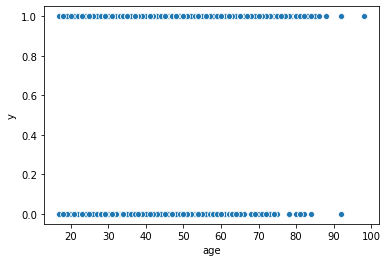

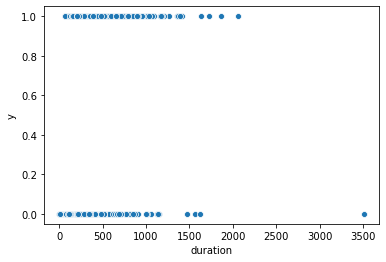

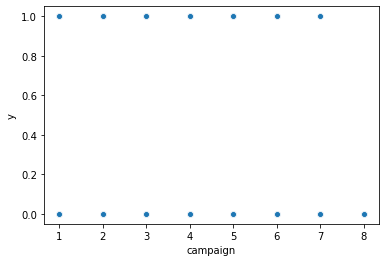

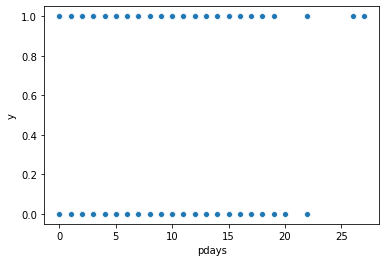

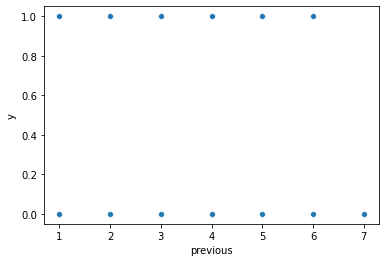

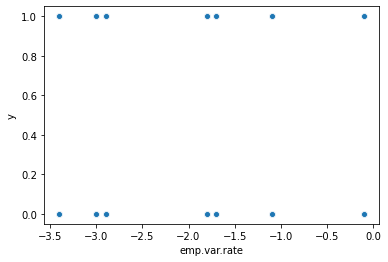

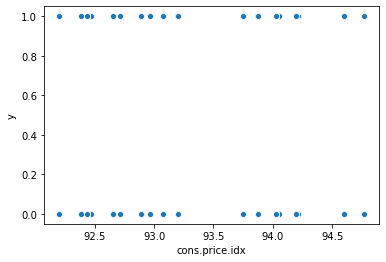

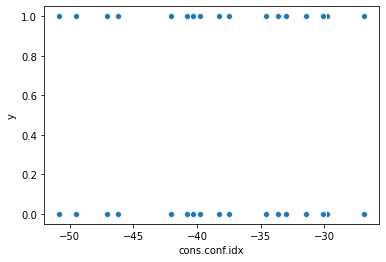

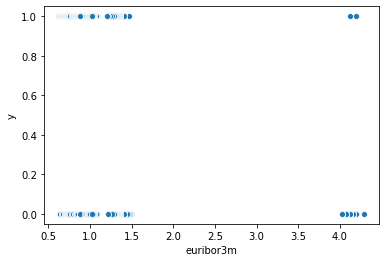

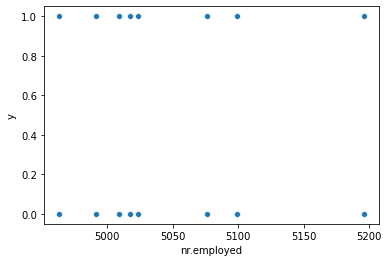

In [47]:
df_1 = df1[df1["cluster"]==9].copy()
for i, col in enumerate(numerical_columns):
    plt.figure(i)
    sns.scatterplot(x= col, y="y", data = df_1)

In [49]:
df_1[numerical_columns+["y"]].corr()["y"]

age               0.088147
duration          0.232905
campaign         -0.117335
pdays            -0.018733
previous          0.104628
emp.var.rate     -0.058036
cons.price.idx    0.151149
cons.conf.idx     0.123554
euribor3m        -0.264753
nr.employed      -0.312123
y                 1.000000
Name: y, dtype: float64

In [48]:
df1.groupby("cluster")[numerical_columns+["y"]].mean().sort_values("y", ascending=False)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
cluster,,,,,,,,,,,
9,42.091048,323.392502,1.815608,5.605968,1.592196,-2.102831,93.342254,-38.603826,1.014774,5031.151109,0.640398
8,40.778388,245.946886,2.203297,835.454212,0.483516,-1.800000,93.097330,-42.650549,1.162745,5055.390110,0.505495
3,44.542705,290.781139,1.689502,977.014235,0.411922,-2.464324,93.096257,-33.540214,1.063661,5014.172865,0.369217
10,40.362083,291.135476,1.961351,999.000000,0.238405,-1.800000,93.105711,-46.530431,1.377235,5094.980879,0.187144
12,37.578251,259.189787,2.256564,999.000000,0.000000,-2.041968,92.912626,-43.454352,1.206191,5086.164875,0.173868
1,38.702841,245.716654,2.107735,962.694159,1.198895,-1.991042,92.989655,-43.363496,1.181901,5079.385596,0.144830
5,40.806600,240.873458,1.896126,999.000000,0.193974,-0.246428,93.197941,-41.632166,3.938289,5185.587862,0.072023
0,40.146886,262.868978,2.675088,999.000000,0.003525,0.562632,93.751083,-40.686722,4.140522,5188.292362,0.070505
7,38.088564,273.918939,3.291125,999.000000,0.000000,1.400000,93.918000,-42.700000,4.961616,5228.100000,0.061116


In [53]:
df1.groupby(["cluster","y"])[["pdays"]].agg(["count","mean", "max", "min"])

pdays                      
          count        mean  max  min
cluster y                            
0       0  1582  999.000000  999  999
        1   120  999.000000  999  999
1       0  2167  979.357637  999    3
        1   367  864.302452  999    3
2       0  3317  999.000000  999  999
        1   151  999.000000  999  999
3       0   709  979.506347  999    6
        1   415  972.756627  999    5
4       0  3590  999.000000  999  999
        1   181  999.000000  999  999
5       0  3234  999.000000  999  999
        1   251  999.000000  999  999
6       0  4225  999.000000  999  999
        1   229  999.000000  999  999
7       0  5131  999.000000  999  999
        1   334  999.000000  999  999
8       0   270  921.892593  999    3
        1   276  750.894928  999    3
9       0   470    5.695745   22    0
        1   837    5.555556   27    0
10      0  1998  999.000000  999  999
        1   460  999.000000  999  999
11      0  5859  999.000000  999  999
        1   178  999.000000  999  999
12      0  3996  999.000000  999  999
        1   841  999.000000  999  999

#### Conclusion:
No confident conclusion can be drawn from the obrained results

### The last approach: Change OHE encoding to LabelEnconding and perform clusterisation

In [93]:
# OHE in binary column
df2 = df.copy()
map_yes_no_dict = {"yes": 1, "no":0}
map_phone_dict = {"cellular": 1, "telephone":0}
for col in ['default', 'housing','loan']:
    df2[col] = df2[col].apply(lambda x: map_yes_no_dict[x])
df2['contact'] = df2['contact'].map(map_phone_dict) 

In [96]:
# label encoding for text features
text_cat_columns = [col for col in df2.columns if df2[col].dtype=="object"]

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df2[text_cat_columns] = df2[text_cat_columns].apply(encoder.fit_transform)

In [97]:
# Scaling for continious variables

numerical_columns = ['age', 'duration','campaign','pdays','previous','emp.var.rate','cons.price.idx',
                     'cons.conf.idx','euribor3m','nr.employed']

scaler = StandardScaler()
df2[numerical_columns] = StandardScaler().fit_transform(df2[numerical_columns])

In [105]:
df2_features = df2.drop("y", axis=1)

In [ ]:
%%time
n_clusters = 20
kmeans_kwargs = {"init": "random", "max_iter": 300, "random_state": 123}

errors = []
for i in range(2, n_clusters+1):
    kmeans = KMeans(n_clusters=i, **kmeans_kwargs)
    kmeans.fit(df2_features)
    errors.append(kmeans.inertia_)

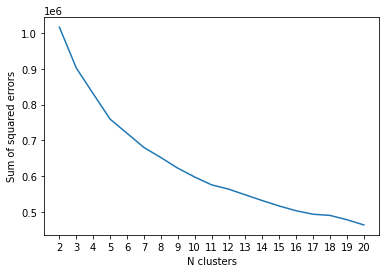

In [107]:
plt.plot(np.arange(2, n_clusters+1), errors)
plt.xlabel("N clusters")
plt.xticks(np.arange(2, n_clusters+1))
plt.ylabel("Sum of squared errors");

There is not so evident which number of clusters to use as the plot is very smooth
Therefore it make sense to try silhouette from sklearn

In [121]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [132]:
%%time
n_clusters = 20
sil_scores = [] # aim to high silhouette_scores
for i in range(2, n_clusters+1):
    kmeans = KMeans(n_clusters=i, random_state=123)
    kmeans.fit(df2_features)
    cluster_labels = kmeans.fit_predict(df2_features)
    silhouette_avg = silhouette_score(df2_features, cluster_labels)
    sil_scores.append(silhouette_avg)
    print("For n_clusters =", i,
          "The average silhouette_score is :", round(silhouette_avg, 3))

For n_clusters = 2 The average silhouette_score is : 0.291
For n_clusters = 3 The average silhouette_score is : 0.206
For n_clusters = 4 The average silhouette_score is : 0.172
For n_clusters = 5 The average silhouette_score is : 0.177
For n_clusters = 6 The average silhouette_score is : 0.166
For n_clusters = 7 The average silhouette_score is : 0.186
For n_clusters = 8 The average silhouette_score is : 0.158
For n_clusters = 9 The average silhouette_score is : 0.182
For n_clusters = 10 The average silhouette_score is : 0.177
For n_clusters = 11 The average silhouette_score is : 0.175
For n_clusters = 12 The average silhouette_score is : 0.186
For n_clusters = 13 The average silhouette_score is : 0.18
For n_clusters = 14 The average silhouette_score is : 0.183
For n_clusters = 15 The average silhouette_score is : 0.175
For n_clusters = 16 The average silhouette_score is : 0.175
For n_clusters = 17 The average silhouette_score is : 0.168
For n_clusters = 18 The average silhouette_score 

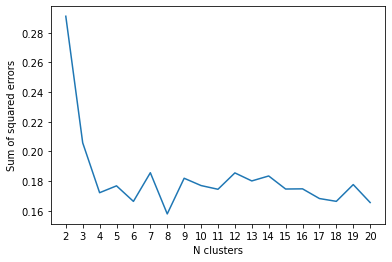

In [133]:
plt.plot(np.arange(2, n_clusters+1), sil_scores)
plt.xlabel("N clusters")
plt.xticks(np.arange(2, n_clusters+1))
plt.ylabel("Sum of squared errors");

The highest silhouette_score is for 2 cluster, so let's see what it is inside

In [134]:
kmeans = KMeans(n_clusters=2, random_state=123)
kmeans.fit(df2_features)
df2["cluster"] = kmeans.predict(df2_features)

In [135]:
df2.groupby("cluster")[numerical_columns+["y"]].mean().sort_values("y", ascending=False)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
cluster,,,,,,,,,,,
0,0.045966,-0.002671,-0.006041,-0.051103,0.046740,-0.044703,-0.036808,0.071815,-0.048630,-0.065992,0.130667
1,-0.028978,0.001684,0.003808,0.032217,-0.029466,0.028182,0.023205,-0.045274,0.030658,0.041604,0.101298
